# NHANES Consolidated Data - Exploratory Data Analysis (EDA)


**Dataset**: NHANES_consolidated.parquet
- **Target Variable**: diabetes_risk (0 = Normal, 1 = Diabetes Risk)
- **Threshold**: HbA1c < 5.7% (Normal) vs >= 5.7% (Risk)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print('Libraries imported successfully')

Libraries imported successfully


## 1. Load Data

In [22]:
df = pd.read_parquet('../data/nhanes_data/NHANES_final.parquet')

print(f'Dataset shape: {df.shape}')
print(f'Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

Dataset shape: (35566, 24)
Memory usage: 6.51 MB


## 2. Dataset Overview

In [23]:
print('='*80)
print('DATASET OVERVIEW')
print('='*80)
print(f'Shape: {df.shape}')
print(f'Rows: {df.shape[0]:,}')
print(f'Columns: {df.shape[1]}')

print(f'\nData types:')
print(df.dtypes)

print(f'\nColumns:')
for i, col in enumerate(df.columns, 1):
    print(f' {i:2d}. {col}')

print(f'\nFirst and last rows:')
print(df.head())   
print(df.tail())  


DATASET OVERVIEW
Shape: (35566, 24)
Rows: 35,566
Columns: 24

Data types:
creatinine              float64
bmi                     float64
waist_cm                float64
weight_kg               float64
height_cm               float64
hypertension              int64
BPX_SYS                 float64
BPX_DIA                 float64
age_years                 int64
income_poverty_ratio    float64
glucose_value           float64
hdl_cholesterol         float64
liver_disease             int64
heart_disease             int64
SLQ                     float64
smoker                    int64
total_cholesterol       float64
TRIGLY                  float64
diabetes_risk             int64
gender_2.0              float64
ethnicity_2.0           float64
ethnicity_3.0           float64
ethnicity_4.0           float64
ethnicity_5.0           float64
dtype: object

Columns:
  1. creatinine
  2. bmi
  3. waist_cm
  4. weight_kg
  5. height_cm
  6. hypertension
  7. BPX_SYS
  8. BPX_DIA
  9. age_years
 10. i

## 3. Target Variable Analysis: diabetes_risk

In [24]:
print('='*80)
print('TARGET VARIABLE ANALYSIS: diabetes_risk')
print('='*80)

class_counts = df['diabetes_risk'].value_counts().sort_index()
class_pcts = df['diabetes_risk'].value_counts(normalize=True).sort_index() * 100

print('\nClass Distribution:')
print(f'\n  0 (Normal, < 5.7%):')
print(f'    Count: {class_counts[0]:,}')
print(f'    Percentage: {class_pcts[0]:.2f}%')

print(f'\n  1 (Diabetes Risk, >= 5.7%):')
print(f'    Count: {class_counts[1]:,}')
print(f'    Percentage: {class_pcts[1]:.2f}%')

imbalance_ratio = class_counts[1] / class_counts[0]
print(f'\nClass Imbalance Ratio: 1:{imbalance_ratio:.2f}')

missing_target = df['diabetes_risk'].isnull().sum()
print(f'\nMissing values: {missing_target} (0.00%)')

TARGET VARIABLE ANALYSIS: diabetes_risk

Class Distribution:

  0 (Normal, < 5.7%):
    Count: 22,826
    Percentage: 64.18%

  1 (Diabetes Risk, >= 5.7%):
    Count: 12,740
    Percentage: 35.82%

Class Imbalance Ratio: 1:0.56

Missing values: 0 (0.00%)


## 4. Target Variable Visualization

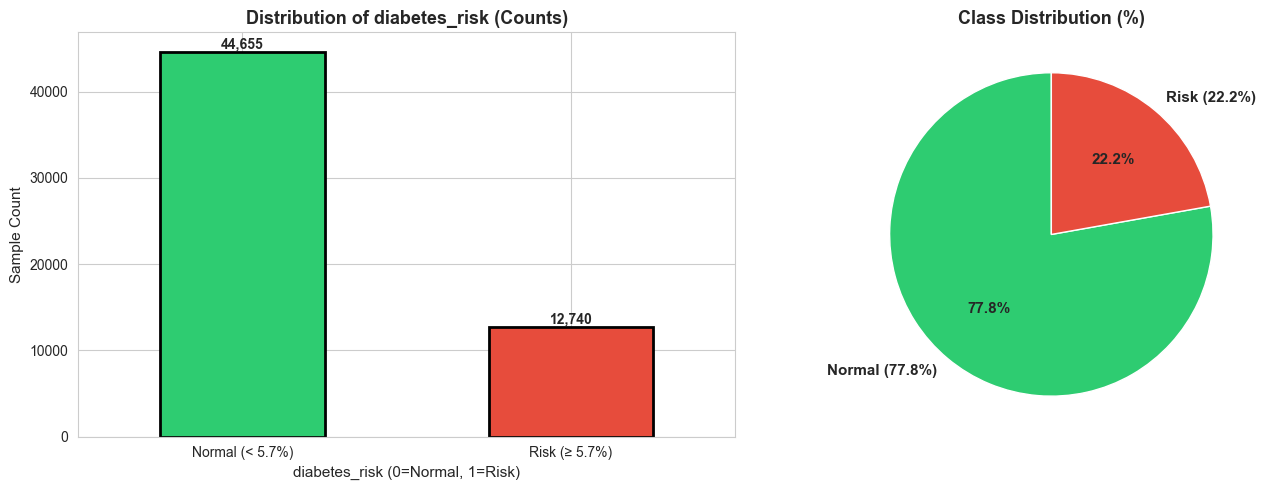

Target variable distribution visualized


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
class_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
ax1.set_title('Distribution of diabetes_risk (Counts)', fontsize=13, fontweight='bold')
ax1.set_xlabel('diabetes_risk (0=Normal, 1=Risk)', fontsize=11)
ax1.set_ylabel('Sample Count', fontsize=11)
ax1.set_xticklabels(['Normal (< 5.7%)', 'Risk (≥ 5.7%)'], rotation=0)

for i, v in enumerate(class_counts):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

ax2 = axes[1]
colors = ['#2ecc71', '#e74c3c']
labels = [f'Normal ({class_pcts[0]:.1f}%)', f'Risk ({class_pcts[1]:.1f}%)']
ax2.pie(class_counts, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Class Distribution (%)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print('Target variable distribution visualized')

## 5. Missing Values Analysis


MISSING VALUES ANALYSIS

Missing values by column:
              Column  Missing_Count  Missing_%
              TRIGLY          40369      70.34
       liver_disease          23309      40.61
       heart_disease          23309      40.61
          creatinine          22810      39.74
              smoker          21903      38.16
       glucose_value          21829      38.03
                 SLQ          19981      34.81
        hypertension          19737      34.39
             BPX_SYS          18453      32.15
             BPX_DIA          18453      32.15
     hdl_cholesterol          17808      31.03
   total_cholesterol          17809      31.03
            waist_cm          11453      19.95
                 bmi           9374      16.33
           height_cm           9288      16.18
income_poverty_ratio           6919      12.06
           weight_kg           6155      10.72


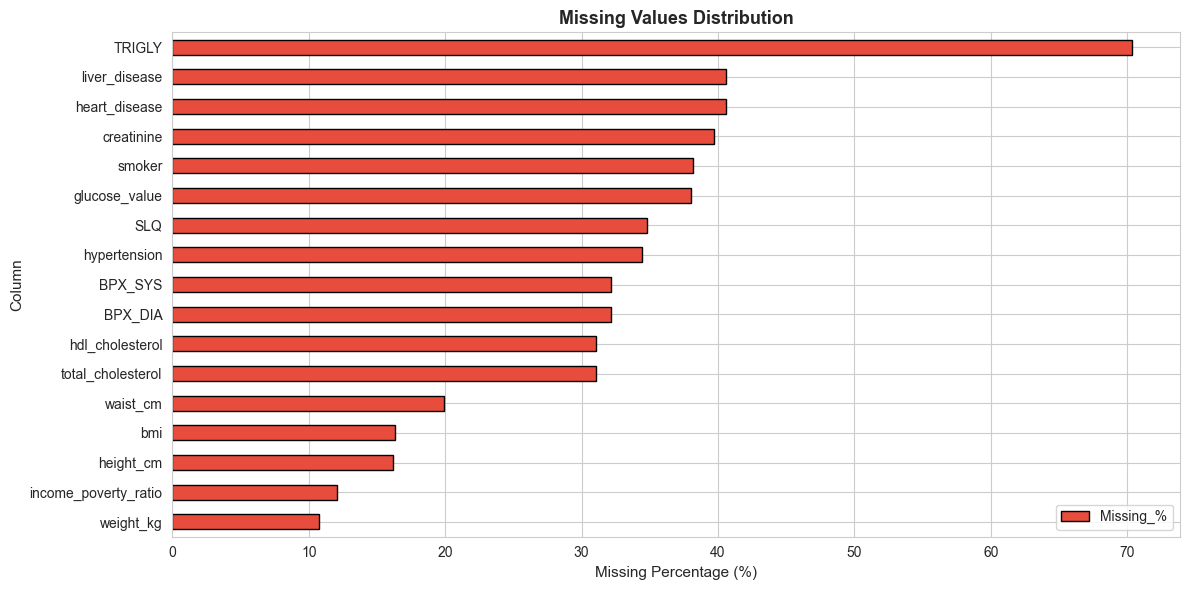

In [14]:
print('\n' + '='*80)
print('MISSING VALUES ANALYSIS')
print('='*80)

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_%': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_%', ascending=False)

print('\nMissing values by column:')
print(missing_data.to_string(index=False))

if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_data.sort_values('Missing_%').plot(
        x='Column', y='Missing_%', kind='barh', ax=ax, color='#e74c3c', edgecolor='black'
    )
    ax.set_xlabel('Missing Percentage (%)', fontsize=11)
    ax.set_ylabel('Column', fontsize=11)
    ax.set_title('Missing Values Distribution', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 6. Feature Analysis by Target Class

In [15]:
print('\n' + '='*80)
print('FEATURE ANALYSIS BY TARGET CLASS')
print('='*80)

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('subject_id')
numeric_features.remove('diabetes_risk')

print(f'\nNumeric features for analysis: {len(numeric_features)} total')

print('\n' + '-'*80)
print('Descriptive Statistics by Target Class')
print('-'*80)

for feature in numeric_features[:5]:
    print(f'\n{feature.upper()}:')
    
    class_0 = df[df['diabetes_risk'] == 0][feature]
    print(f'  Class 0 (Normal):')
    print(f'    n={class_0.notna().sum():,}, Mean={class_0.mean():.2f}, Std={class_0.std():.2f}')
    print(f'    Min={class_0.min():.2f}, Median={class_0.median():.2f}, Max={class_0.max():.2f}')
    
    class_1 = df[df['diabetes_risk'] == 1][feature]
    print(f'  Class 1 (Risk):')
    print(f'    n={class_1.notna().sum():,}, Mean={class_1.mean():.2f}, Std={class_1.std():.2f}')
    print(f'    Min={class_1.min():.2f}, Median={class_1.median():.2f}, Max={class_1.max():.2f}')
    
    t_stat, p_value = stats.ttest_ind(class_0.dropna(), class_1.dropna())
    significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
    print(f'  T-test: p-value={p_value:.4f} {significance}')


FEATURE ANALYSIS BY TARGET CLASS

Numeric features for analysis: 20 total

--------------------------------------------------------------------------------
Descriptive Statistics by Target Class
--------------------------------------------------------------------------------

CREATININE:
  Class 0 (Normal):
    n=22,248, Mean=0.83, Std=0.38
    Min=0.16, Median=0.80, Max=14.97
  Class 1 (Risk):
    n=12,337, Mean=0.94, Std=0.53
    Min=0.26, Median=0.86, Max=17.41
  T-test: p-value=0.0000 ***

BMI:
  Class 0 (Normal):
    n=35,468, Mean=24.40, Std=7.43
    Min=11.10, Median=23.50, Max=82.90
  Class 1 (Risk):
    n=12,553, Mean=31.39, Std=7.70
    Min=13.40, Median=30.10, Max=92.30
  T-test: p-value=0.0000 ***

WAIST_CM:
  Class 0 (Normal):
    n=33,942, Mean=82.89, Std=21.62
    Min=38.70, Median=82.80, Max=187.50
  Class 1 (Risk):
    n=12,000, Mean=105.30, Std=16.86
    Min=54.60, Median=104.00, Max=178.00
  T-test: p-value=0.0000 ***

WEIGHT_KG:
  Class 0 (Normal):
    n=38,662, Me

## 7. Feature Distributions - Box Plots

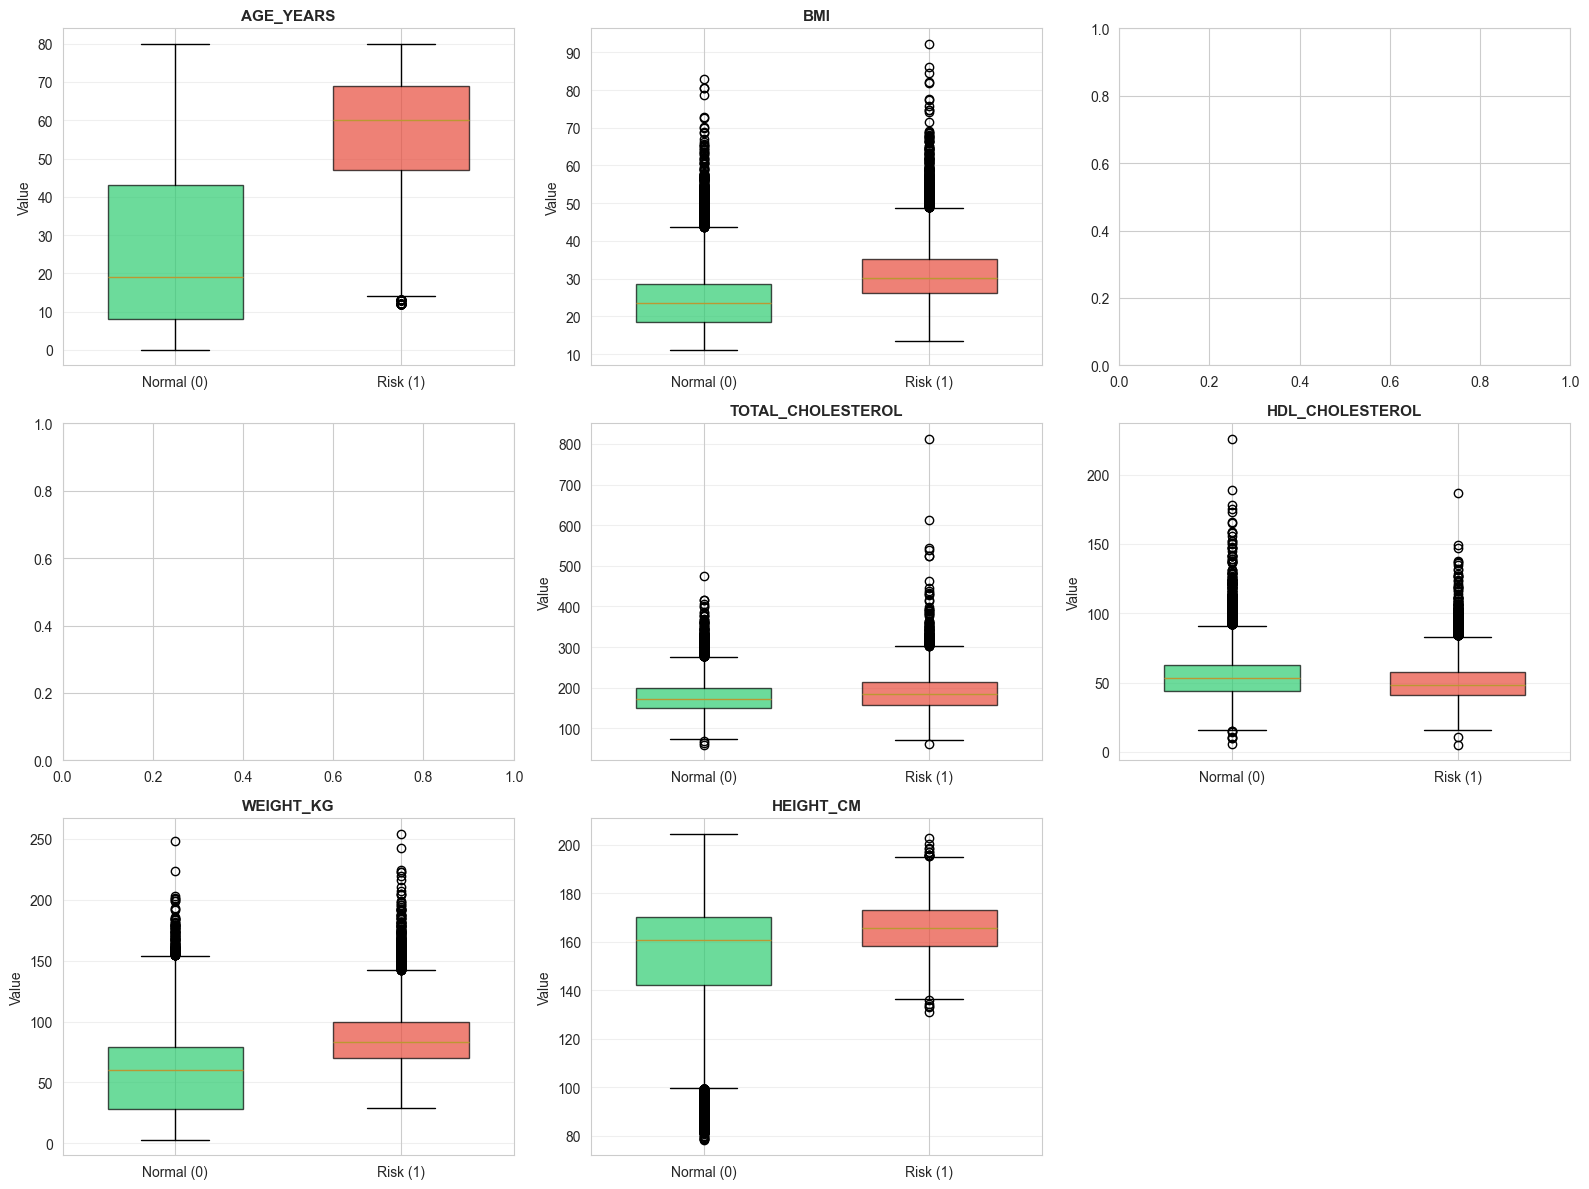

Feature distributions by target class visualized


In [16]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

selected_features = ['age_years', 'bmi', 'systolic_bp', 'diastolic_bp', 
                    'total_cholesterol', 'hdl_cholesterol', 'weight_kg', 'height_cm', 'waist_cm']

for idx, feature in enumerate(selected_features):
    if feature in df.columns:
        ax = axes[idx]
        data_to_plot = [df[df['diabetes_risk'] == 0][feature].dropna(),
                        df[df['diabetes_risk'] == 1][feature].dropna()]
        
        bp = ax.boxplot(data_to_plot, labels=['Normal (0)', 'Risk (1)'],
                        patch_artist=True, widths=0.6)
        
        colors = ['#2ecc71', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(f'{feature.upper()}', fontsize=11, fontweight='bold')
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(axis='y', alpha=0.3)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print('Feature distributions by target class visualized')

## 8. Correlation Analysis


CORRELATION WITH TARGET VARIABLE

Features most correlated with diabetes_risk:
glucose_value        0.594846
age_years            0.498695
waist_cm             0.433156
weight_kg            0.391342
bmi                  0.379199
BPX_SYS              0.317487
height_cm            0.247942
BPX_DIA              0.177883
TRIGLY               0.170906
total_cholesterol    0.132165


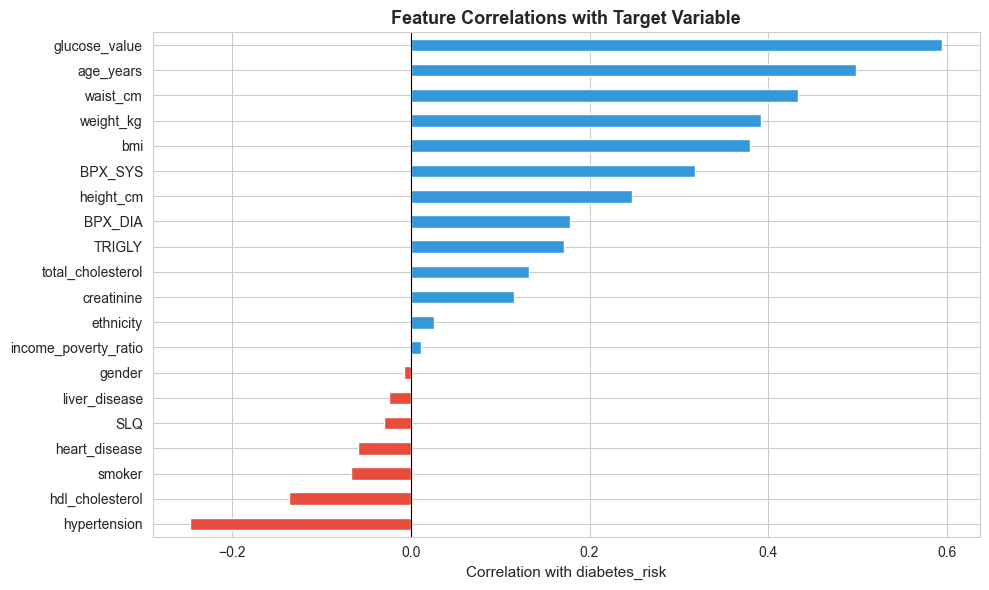

In [17]:
print('\n' + '='*80)
print('CORRELATION WITH TARGET VARIABLE')
print('='*80)

correlations = df[numeric_features + ['diabetes_risk']].corr()['diabetes_risk'].sort_values(ascending=False)
correlations = correlations[correlations.index != 'diabetes_risk']

print('\nFeatures most correlated with diabetes_risk:')
print(correlations.head(10).to_string())

fig, ax = plt.subplots(figsize=(10, 6))
correlations.sort_values().plot(kind='barh', ax=ax, color=['#e74c3c' if x < 0 else '#3498db' for x in correlations.sort_values()])
ax.set_xlabel('Correlation with diabetes_risk', fontsize=11)
ax.set_title('Feature Correlations with Target Variable', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

## 9. Demographic Analysis by Target Class

In [18]:
print('\n' + '='*80)
print('DEMOGRAPHIC ANALYSIS')
print('='*80)

if 'gender' in df.columns:
    print('\nGender Distribution by Target Class:')
    gender_target = pd.crosstab(df['gender'], df['diabetes_risk'], margins=True)
    print(gender_target)

if 'age_years' in df.columns:
    print('\nAge Group Analysis:')
    df['age_group'] = pd.cut(df['age_years'], 
                              bins=[0, 18, 35, 50, 65, 100],
                              labels=['< 18', '18-34', '35-49', '50-64', '65+'])
    age_target = pd.crosstab(df['age_group'], df['diabetes_risk'], normalize='index') * 100
    print('\nPercentage by Age Group:')
    print(age_target.round(2))


DEMOGRAPHIC ANALYSIS

Gender Distribution by Target Class:
diabetes_risk      0      1    All
gender                            
1.0            21732   6315  28047
2.0            22923   6425  29348
All            44655  12740  57395

Age Group Analysis:

Percentage by Age Group:
diabetes_risk      0      1
age_group                  
< 18           97.78   2.22
18-34          89.01  10.99
35-49          70.63  29.37
50-64          50.26  49.74
65+            47.75  52.25


## 10. Summary Statistics

In [19]:
print('\n' + '='*80)
print('FINAL SUMMARY')
print('='*80)

print(f'\nDataset Statistics:')
print(f'  Total Samples: {len(df):,}')
print(f'  Total Features: {len(df.columns)}')
print(f'  Numeric Features: {len(numeric_features)}')

print(f'\nTarget Variable:')
print(f'  Normal (0): {class_counts[0]:,} ({class_pcts[0]:.2f}%)')
print(f'  Risk (1): {class_counts[1]:,} ({class_pcts[1]:.2f}%)')
print(f'  Imbalance Ratio: 1:{imbalance_ratio:.2f}')

print(f'\nData Quality:')
print(f'  Complete Cases: {len(df.dropna()):,}')
print(f'  Cases with Missing Values: {len(df[df.isnull().any(axis=1)]):,}')
print(f'  Total Missing Cells: {df.isnull().sum().sum():,}')

print(f'\nEDA Complete - Ready for modeling')


FINAL SUMMARY

Dataset Statistics:
  Total Samples: 57,395
  Total Features: 23
  Numeric Features: 20

Target Variable:
  Normal (0): 44,655 (77.80%)
  Risk (1): 12,740 (22.20%)
  Imbalance Ratio: 1:0.29

Data Quality:
  Complete Cases: 11,371
  Cases with Missing Values: 46,024
  Total Missing Cells: 310,726

EDA Complete - Ready for modeling


In [20]:
df.describe(include='all')

,subject_id,creatinine,bmi,waist_cm,weight_kg,height_cm,hypertension,BPX_SYS,BPX_DIA,age_years,...,glucose_value,hdl_cholesterol,liver_disease,heart_disease,SLQ,smoker,total_cholesterol,TRIGLY,diabetes_risk,age_group
count,57395.000000,34585.000000,48021.000000,45942.000000,51240.000000,48107.000000,37658.000000,38942.000000,38942.000000,57395.000000,...,35566.000000,39587.000000,34086.000000,34086.000000,37414.000000,35492.000000,39586.000000,17026.000000,57395.000000,55628
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,< 18
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20705
mean,100827.628975,0.871637,26.223671,88.740016,64.516408,156.489098,1.666419,119.473268,69.053849,33.575468,...,5.717733,53.534216,1.965235,1.966907,7.479099,1.598163,180.096903,111.064313,0.221971,NaN
std,25545.916884,0.441036,8.104075,22.728484,32.350587,22.605590,0.534384,18.912711,13.994792,25.135599,...,1.060445,15.043671,0.360342,0.326820,2.419755,0.539264,41.232220,94.638196,0.415575,NaN
min,62161.000000,0.160000,11.100000,38.700000,2.700000,78.300000,1.000000,52.000000,0.000000,0.000000,...,2.800000,5.000000,1.000000,1.000000,2.000000,1.000000,59.000000,10.000000,0.000000,NaN
25%,78149.500000,0.680000,20.200000,72.800000,42.300000,150.900000,1.000000,106.000000,61.000000,10.000000,...,5.200000,43.000000,2.000000,2.000000,6.500000,1.000000,151.000000,62.000000,0.000000,NaN
50%,92498.000000,0.820000,25.400000,89.700000,67.200000,162.200000,2.000000,116.000000,69.000000,30.000000,...,5.500000,51.000000,2.000000,2.000000,7.500000,2.000000,176.000000,90.000000,0.000000,NaN
75%,122406.500000,0.980000,30.800000,104.200000,85.200000,171.300000,2.000000,129.000000,78.000000,56.000000,...,5.800000,62.000000,2.000000,2.000000,8.000000,2.000000,205.000000,133.000000,0.000000,NaN
